
# $l^p$-FGSM in TensorFlow: A Novel Solution to Catastrophic Overfitting in Fast Adversarial Training

Welcome to the TensorFlow implementation of the $l^p$-Fast Gradient Sign Method ($l^p$-FGSM), a novel method from our study, "An $l^p$ Norm Solution to Catastrophic Overfitting in Fast Adversarial Training." This notebook aims to provide a comprehensive and interactive exploration of the techniques and insights introduced in our research.

 ## Objective

Our primary aim is to demonstrate how the choice of the $p$ value in the $l^p$ norm can be useful in enhancing adversarial robustness and mitigating issues like catastrophic overfitting.

## Overview

Adversarial training has emerged as a powerful tool for enhancing the robustness of deep neural networks against adversarial attacks. Traditional methods, while effective, often come with considerable computational costs. Fast adversarial training methods like the Fast Gradient Sign Method (FGSM) offer a more efficient alternative. However, they also introduce the challenge of catastrophic overfitting, where models become robust against single-step attacks but remain surprisingly vulnerable to multi-step variants.

Our work focuses on this pivotal issue, examining the prevalence of catastrophic overfitting under different norm constraints. Through empirical analysis, we discovered that catastrophic overfitting is more pronounced under the $ l^\infty $ norm than the $ l^2 $ norm. Building on this insight, we developed the $l^p$-FGSM framework, which generalizes adversarial perturbation creation across various norms. This framework allows a seamless transition from $ l^2 $ to $ l^\infty $ attacks,

In this notebook, we delve into the $l^p$-FGSM method, addressing the challenge of catastrophic overfitting in fast adversarial training and providing a hands-on experience with our proposed solution.

### Key Highlights:
- TensorFlow-based implementation of the $l^p$-FGSM method.
- Interactive analysis of how varying $ l^p $ norms influence adversarial robustness.
- Interactive demonstrations and empirical evidence supporting the efficacy of the $l^p$-FGSM approach.


In [1]:
# @title **I.** Imports

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
import math
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam, AdamW, SGD
import os

seed = 888
np.random.seed(seed)  # For NumPy random numbers
tf.random.set_seed(seed)  # For TensorFlow random numbers


!pip install git+https://github.com/cleverhans-lab/cleverhans.git > /dev/null # FOR PGD50 evaluation
#!pip install tensorflow-addons

  Running command git clone --filter=blob:none --quiet https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-req-build-zjbdne9t


In [2]:
# @title **II.** Configuration Parameters

dataset_name = "CIFAR10"  # Change this to "SVHN" ,"CIFAR10" "CIFAR100" as needed ** Future rev
num_classes = 10
batch_size = 1024
epochs=30
weight_decay =5e-4
init_shape = (32, 32, 3)
activation = "relu"
dropout=0.1

In [3]:
# @title **III.** Dataset Loader

(x_train_, y_train), (x_test_, y_test) = cifar10.load_data()

# Normalize the data between [0,1]
x_train = x_train_.astype("float32") / 255.0
x_test = x_test_.astype("float32") / 255.0

# Standardize (Optional)
#remove_mean = False
#if remove_mean:
#    mean_train = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 1, 3)
#    std_train = np.array([0.2471, 0.2435, 0.2616]).reshape(1, 1, 1, 3)
#    x_train = (x_train - mean_train) / std_train
#    x_test = (x_test - mean_train) / std_train

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Preprocessing function (Optional)
def divide_by_max(img):
    return img /img.max()

# Set up the ImageDataGenerator
generator = ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32.0,
                               height_shift_range=5./32.0,
                               horizontal_flip=True)
                               #preprocessing_function=divide_by_max)


# Fit the generator
generator.fit(x_train, seed=seed, augment=False)

In [4]:
# @title **IV.** WRN (Wide Residual Networks)


#! Code forked and modified from https://github.com/titu1994/Wide-Residual-Networks , added for reference (See Appendix)

from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras import layers
from keras.regularizers import l2
from keras import backend as K



def initial_conv(input):
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation(activation)(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)
    ip = (ip-0.5) # [-0.5,0.5], #### MODIFICATION

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation(activation)(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)
    #x = Dropout(0.1)(x)
    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay))(x)
    x = layers.Activation('Softmax')(x)# important
    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

In [5]:
# @title **V.** Pre-Training: (Optional)
# Create the WRN-28-8 model
model = create_wide_residual_network(init_shape, nb_classes=10, N=4, k=8, dropout=dropout)
# Define the optimizer
model.compile(optimizer = AdamW(learning_rate=0.001,weight_decay=0.0), loss = "categorical_crossentropy", metrics = ["accuracy"])

pretrain=False

if pretrain:
    model.fit(generator.flow(x_train, y_train, batch_size=batch_size), batch_size=batch_size,
              epochs=100, validation_data=(x_test, y_test))
    model.evaluate(x_test, y_test)


Wide Residual Network-28-8 created.


In [6]:
# @title **VI.** $l^p$-FGSM Class
# Summed and Non-Reduced Cross-Entropy
ccs = tf.keras.losses.CategoricalCrossentropy(reduction='sum')
ccn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE) # to get access to the per-sample loss

class lp_fgsm(keras.models.Model):
    '''
    Main class to implement lp-FGSM.
    '''

    def __init__(self, base_model, p=32.0, eps=8.0/255.0, cce=None, add_noise=True, vareps=1e-12, *args, **kwargs):
        super(lp_fgsm, self).__init__(*args, **kwargs)
        self.base_model = base_model
        self.p = p
        self.eps = eps
        self.cce = tf.keras.losses.CategoricalCrossentropy()
        self.add_noise = add_noise
        self.vareps = vareps
        self.q = p / (p - 1.0)  # Dual norm


    @tf.function(jit_compile=True)
    def call(self, inputs, training=True):
        return self.base_model(inputs, training=training)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        if self.add_noise:
            x_rnd = tf.random.uniform(tf.shape(x), minval=-1.0, maxval=1.0)
            Ups_ = tf.pow(tf.reduce_sum(tf.pow(tf.abs(x_rnd), self.q), axis=[1, 2, 3], keepdims=True), 1.0 / self.q)
            Ups = tf.pow(self.vareps + tf.abs(x_rnd) / (Ups_), self.q - 1.0)
            x_rnd = tf.sign(x_rnd) * Ups
            x_aug = x + self.eps * x_rnd
        else:
            x_aug = x

        trainable_vars = self.base_model.trainable_variables

        with tf.GradientTape(watch_accessed_variables=False) as inner_tape:
            inner_tape.watch(x_aug)
            probs_aug = self(x_aug, training=True)
            loss_sum = self.cce(y, probs_aug)
        dlx = inner_tape.gradient(loss_sum, x_aug)
        dlxq = tf.pow(tf.reduce_sum(tf.pow(tf.abs(dlx), self.q), axis=[1, 2, 3], keepdims=True), 1.0 / self.q)
        Upsilon = tf.pow(self.vareps + tf.abs(dlx) / (dlxq), self.q - 1.0)
        dlxn = tf.sign(dlx) * Upsilon

        #x_adv = x + self.eps * dlxn
        x_adv = x + self.eps*x_rnd + self.eps*(dlxn)
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(trainable_vars)
            probs_adv = self(x_adv, training=True)
            losses_adv = self.cce(y, probs_adv)
            loss_total = tf.reduce_mean(losses_adv)

        grads = tape.gradient(loss_total, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        self.compiled_metrics.update_state(y, probs_adv)
        return {m.name: m.result() for m in self.metrics}


In [7]:
# @title **VII.** Adverserial Checkpoint


from cleverhans.tf2.attacks import fast_gradient_method, projected_gradient_descent
from tensorflow.keras.callbacks import Callback

from tensorflow.linalg import norm

class AdversarialCheckpoint_vFull(Callback):
    def __init__(self, x_val, y_val, filepath, epsilon=8.0/255.0, norm=np.inf, batch_size=1024):
        super(AdversarialCheckpoint_vFull, self).__init__()
        self.x_val = x_val
        self.y_val = y_val
        self.epsilon = epsilon
        self.norm = norm
        self.best_adv_accuracy = 0.0
        self.filepath = filepath
        self.adv_accuracies = []
        self.adv_accuracies_l2 = []
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        num_batches = int(np.ceil(len(self.x_val) / float(self.batch_size)))
        total_correct = 0
        total_correct_l2 = 0
        total_samples = 0

        for batch_idx in range(num_batches):
            start_idx = batch_idx * self.batch_size
            end_idx = min((batch_idx + 1) * self.batch_size, len(self.x_val))

            x_val_batch = self.x_val[start_idx:end_idx]
            y_val_batch = self.y_val[start_idx:end_idx]

            # For Linf
            x_val_adv = projected_gradient_descent.projected_gradient_descent(
                model_fn=self.model, x=x_val_batch, eps=self.epsilon, norm=self.norm,
                eps_iter=2.0/255.0, nb_iter=50, clip_min=0.0, clip_max=1.0
            )
            predictions = np.argmax(self.model.predict(x_val_adv), axis=1)
            actuals = np.argmax(y_val_batch, axis=1)
            total_correct += np.sum(predictions == actuals)

            # For L2
            x_val_adv_l2 = projected_gradient_descent.projected_gradient_descent(
                model_fn=self.model, x=x_val_batch, eps=0.5, norm=2,
                eps_iter=4.0/255.0, nb_iter=50, clip_min=0.0, clip_max=1.0
            )
            predictions_l2 = np.argmax(self.model.predict(x_val_adv_l2), axis=1)
            total_correct_l2 += np.sum(predictions_l2 == actuals)

            total_samples += len(x_val_batch)

        adv_accuracy = total_correct / total_samples
        adv_accuracy_l2 = total_correct_l2 / total_samples

        self.adv_accuracies.append(adv_accuracy)
        self.adv_accuracies_l2.append(adv_accuracy_l2)

        print(f"\n Mean Linf adversarial accuracy at the end of epoch {epoch + 1}: {adv_accuracy * 100:.2f}%")
        print(f"\n Mean L2 adversarial accuracy at the end of epoch {epoch + 1}: {adv_accuracy_l2 * 100:.2f}%")

        if adv_accuracy > self.best_adv_accuracy:
            print(f"Adversarial accuracy improved from {self.best_adv_accuracy * 100:.2f}% to {adv_accuracy * 100:.2f}%")
            self.best_adv_accuracy = adv_accuracy
            #self.model.save(self.filepath)
            #print(f"Model saved at {self.filepath}")


In [8]:
# @title **VIII.** Cyclic Learning Rate
class CyclicLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_max, lr_min, nb_epochs):
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.nb_epochs = nb_epochs

    def __call__(self, step):
        epoch = tf.cast(step // self.nb_epochs, dtype=tf.float32)
        cycle = tf.constant(np.pi, dtype=tf.float32) * epoch / tf.cast(self.nb_epochs, dtype=tf.float32)
        return self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + tf.math.cos(cycle))

# Parameters
lr_max = 0.2
lr_min = 0.01
nb_epochs = 30

# Create CyclicLR instance
cyclic_lr_schedule = CyclicLR(lr_max, lr_min, nb_epochs)

# **IX.** Adversarial Training

In [9]:
eps = 8.0/255.0
vareps = 1e-12 # stability
p = 32
add_noise = True
batch_size = 128
model_lqr = lp_fgsm(model,p=p, eps=eps, vareps=vareps, add_noise=add_noise)

In [10]:
model_lqr.compile(optimizer=SGD(learning_rate=cyclic_lr_schedule, momentum=0.9,weight_decay=weight_decay), loss="categorical_crossentropy", metrics=["accuracy"])
#model_lqr.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=weight_decay), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
images_ = x_test[0:512, :, :, :] # just a portion for illustration
labels_ = y_test[0:512, :]
main_folder = 'saved_models/'
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

save_callback = ModelCheckpoint(filepath=main_folder+'model_weights_epoch_{epoch:02d}.h5', save_weights_only=True)

callbacks_list = [save_callback, AdversarialCheckpoint_vFull(x_val=images_, y_val=labels_, filepath='best_model.h5',epsilon=8.0/255.0, norm=np.inf)]
model_lqr.fit(generator.flow(x_train, y_train, batch_size=batch_size), batch_size=batch_size, epochs=30, validation_data=(x_test, y_test), callbacks=callbacks_list, verbose=1)

Epoch 1/30
  6/391 [..............................] - ETA: 32s - accuracy: 0.1055

16/16 [==============================] - 0s 6ms/step

 Mean Linf adversarial accuracy at the end of epoch 1: 37.11%

 Mean L2 adversarial accuracy at the end of epoch 1: 40.82%
Adversarial accuracy improved from 0.00% to 37.11%
391/391 [==============================] - 134s 284ms/step - accuracy: 0.2334 - val_loss: 9.1871 - val_accuracy: 0.4406
Epoch 2/30
16/16 [==============================] - 0s 6ms/step

 Mean Linf adversarial accuracy at the end of epoch 2: 39.84%

 Mean L2 adversarial accuracy at the end of epoch 2: 49.80%
Adversarial accuracy improved from 37.11% to 39.84%
391/391 [==============================] - 52s 132ms/step - accuracy: 0.3077 - val_loss: 8.7861 - val_accuracy: 0.5159
Epoch 3/30
16/16 [==============================] - 0s 6ms/step

 Mean Linf adversarial accuracy at the end of epoch 3: 41.02%

 Mean L2 adversarial accuracy at the end of epoch 3: 48.44%
Adversarial accuracy improved from 39.84% to 41.02%
391/391 [==============================] - 52s 132ms/

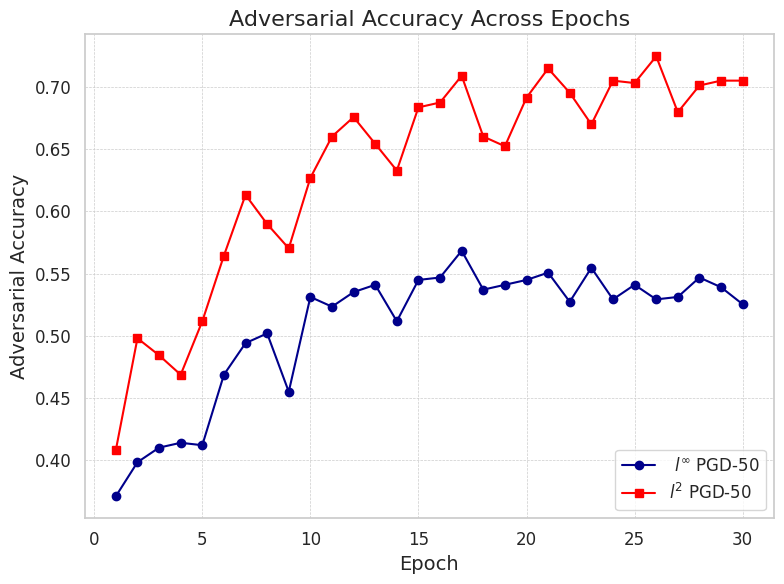

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply seaborn style
sns.set(style="whitegrid")

# Simulated data; replace these with your real data
nb_epochs = 30
epochs = np.arange(1, nb_epochs + 1)

adv_accuracies_l2_vs_linf = callbacks_list[1].adv_accuracies
adv_accuracies_l2_vs_l2 = callbacks_list[1].adv_accuracies_l2

# Create the plot
plt.figure(figsize=(8, 6))

# Plot data with markers
plt.plot(epochs, adv_accuracies_l2_vs_linf, label=' $l^{\infty}$ PGD-50', color='darkblue', marker='o', markersize=6)
plt.plot(epochs, adv_accuracies_l2_vs_l2, label='$l^2$ PGD-50', color='red', marker='s', markersize=6)

# Configure plot parameters
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Adversarial Accuracy', fontsize=14)
plt.title('Adversarial Accuracy Across Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Tight layout for saving
plt.tight_layout()

# Optionally, uncomment the next line to save the figure
# plt.savefig("adversarial_accuracy_with_markers.png", dpi=300)

# Show the plot
plt.show()
